# Questão 3 - Clusterização

Execute os algoritmos de agrupamento K-means e Hierárquico com diferentes valores de clusters e escolha o melhor resultado.
 
 
Para o hierárquico, varie entre o single e complete linkage e analise os resultados obtidos.
Para o k-means, inicialize os centroides aleatoriamente e avalie o impacto da inicialização nos resultados encontrados.
 
 
<b>Bônus</b>: normalizar os dados e executar novamente os algoritmos para analisar os resultados gerados.
Fazer visualização dos clusters encontrados com PCA ou t-SNE.

## Preliminares
Importação de dependências, carregamento da base de dados e observação inicial dos dados.

In [2]:
from scipy import stats

import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn import decomposition
from sklearn import manifold
from sklearn import cluster
from sklearn import model_selection
from sklearn import metrics

In [3]:
df = pd.read_csv('Live.csv', delimiter = ',') # Abrir base de dados

df.head()

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4
0,246675545449582_1649696485147474,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0,NaN,NaN,NaN,NaN
1,246675545449582_1649426988507757,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0,NaN,NaN,NaN,NaN
2,246675545449582_1648730588577397,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0,NaN,NaN,NaN,NaN
3,246675545449582_1648576705259452,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0,NaN,NaN,NaN,NaN
4,246675545449582_1645700502213739,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0,NaN,NaN,NaN,NaN


Uma análise inicial indica que as colunas 'Column1', 'Column2', 'Column3' e 'Column4' não contém alguma informação.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 16 columns):
status_id           7050 non-null object
status_type         7050 non-null object
status_published    7050 non-null object
num_reactions       7050 non-null int64
num_comments        7050 non-null int64
num_shares          7050 non-null int64
num_likes           7050 non-null int64
num_loves           7050 non-null int64
num_wows            7050 non-null int64
num_hahas           7050 non-null int64
num_sads            7050 non-null int64
num_angrys          7050 non-null int64
Column1             0 non-null float64
Column2             0 non-null float64
Column3             0 non-null float64
Column4             0 non-null float64
dtypes: float64(4), int64(9), object(3)
memory usage: 881.4+ KB


Para se ter certeza desta observação, verifica-se a quantia de dados faltantes em cada coluna:

In [5]:
df.isnull().sum()

status_id              0
status_type            0
status_published       0
num_reactions          0
num_comments           0
num_shares             0
num_likes              0
num_loves              0
num_wows               0
num_hahas              0
num_sads               0
num_angrys             0
Column1             7050
Column2             7050
Column3             7050
Column4             7050
dtype: int64

De fato estas 4 colunas não contém nenhuma informação, e portanto serão descartadas:

In [6]:
df.drop(columns = ['Column1', 'Column2', 'Column3', 'Column4'], inplace = True)

Após eliminar estas quatro colunas não restam atributos faltando, contudo ainda é necessário analisar melhor os atributos que não estão em formato numérico: 'status_id', 'status_type' e 'status_published', uma vez que é necessária fazer a conversão destes para poder serem usados pelo algoritmo de aprendizagem de máquina.

## Tratando atributos não numéricos

In [7]:
unique = df['status_id'].unique()
print("Valores únicos de status_id:", unique, "\nTamanho:", len(unique), "\n")
unique = df['status_type'].unique()
print("Valores únicos de status_type:", unique, "\nTamanho:", len(unique), "\n")
unique = df['status_published'].unique()
print("Valores únicos de status_published:", unique, "\nTamanho:", len(unique))

Valores únicos de status_id: ['246675545449582_1649696485147474' '246675545449582_1649426988507757'
 '246675545449582_1648730588577397' ...
 '1050855161656896_1060126464063099' '1050855161656896_1058663487542730'
 '1050855161656896_1050858841656528'] 
Tamanho: 6997 

Valores únicos de status_type: ['video' 'photo' 'link' 'status'] 
Tamanho: 4 

Valores únicos de status_published: ['4/22/2018 6:00' '4/21/2018 22:45' '4/21/2018 6:17' ... '9/21/2016 23:03'
 '9/20/2016 0:43' '9/10/2016 10:30'] 
Tamanho: 6913


O atributo status_type é o que possui a menor cardinalidade entre os atributos não numéricos, podendo assumir 4 valores diferentes.

Enquanto o atributo status_published, apesar de ter vários valores distintos, aparenta se tratar da data e hora no qual uma publicação foi realizada, esta informação poderia ser dividida em mais atributos.

Por fim, o status_id possui uma alta cardinalidade, pelo ver, este atributo parece conter um código identificador para cada publicação, contudo, não é possível garantir isso ainda, pois existem pelo menos um valor distinto deste atributo que ocorre mais de uma vez nesta base de dados.

### status_type
Este atributo é do tipo categórico e deve ser convertido para númerico usando one-hot encoding:

In [8]:
oh = pd.get_dummies(df['status_type'])

df = df.drop(columns = ['status_type'])

df = df.join(oh)

df.head()

,status_id,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,link,photo,status,video
0,246675545449582_1649696485147474,4/22/2018 6:00,529,512,262,432,92,3,1,1,0,0,0,0,1
1,246675545449582_1649426988507757,4/21/2018 22:45,150,0,0,150,0,0,0,0,0,0,1,0,0
2,246675545449582_1648730588577397,4/21/2018 6:17,227,236,57,204,21,1,1,0,0,0,0,0,1
3,246675545449582_1648576705259452,4/21/2018 2:29,111,0,0,111,0,0,0,0,0,0,1,0,0
4,246675545449582_1645700502213739,4/18/2018 3:22,213,0,0,204,9,0,0,0,0,0,1,0,0


### status_published
Este atributo contém informações sobre a data e hora de uma publicação, então pode ser dividida em outros atributos, no caso serão criados os atributos 'day', 'month', 'year' e 'time' a partir do atributo original, sendo que 'time' será medido em minutos, com o propósito de combinar as horas com os minutos em uma coluna apenas.

In [9]:
dt = df['status_published'].to_list()
times = []
years = []
months = []
days = []

for d in dt:
    split = d.split(" ")
    split2 = split[0].split("/")
    
    years.append(int(split2[0]))
    months.append(int(split2[1]))
    days.append(int(split2[2]))
    
    split2 = split[1].split(':')
    times.append((int(split2[0]) * 60 + int(split2[1])))
    
dt_df = pd.DataFrame({"day": days, "month": months, "year": years, "time": times})

df = df.join(dt_df)
df.drop(columns = ['status_published'], inplace = True)

df.head()

,status_id,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,link,photo,status,video,day,month,year,time
0,246675545449582_1649696485147474,529,512,262,432,92,3,1,1,0,0,0,0,1,2018,22,4,360
1,246675545449582_1649426988507757,150,0,0,150,0,0,0,0,0,0,1,0,0,2018,21,4,1365
2,246675545449582_1648730588577397,227,236,57,204,21,1,1,0,0,0,0,0,1,2018,21,4,377
3,246675545449582_1648576705259452,111,0,0,111,0,0,0,0,0,0,1,0,0,2018,21,4,149
4,246675545449582_1645700502213739,213,0,0,204,9,0,0,0,0,0,1,0,0,2018,18,4,202


### status_id
Este atributo não me aparenta ter alguma utilidade original, imagino que se trata do valor identificador para uma publicação, contudo, darei uma segunda chance para este mostrar seu valor.

Como os valores deste atributo estão separados por um '_', vejamos como a parte direita deste atributo se relaciona a parte esquerda:

In [10]:
dt = df['status_id'].to_list()
left = []
right = []

for d in dt:
    split = d.split("_")
    left.append(split[0])
    right.append(split[1])

lr_df = pd.DataFrame({"left_status_id": left, "right_status_id": right})

df = df.join(lr_df)
df.drop(columns = ['status_id'], inplace = True)

print("Quantidade de valores únicos para left_status_id:" ,len(df['left_status_id'].unique()))

Quantidade de valores únicos para left_status_id: 9


O número de valores únicos para a parte esquerda é bastante baixo, contudo, não é possível fazer alguma conclusão sobre isso pelo fato de que talvez os valores atribuídos para a coluna 'status_id' original não sigam alguma ordem lógica (e.g. tenham sido gerados por alguma função de dispersão). 

Para tentar adquirir mais informações, com o propósito de facilitar a decisão a ser tomada em relação a este atributo, vejamos como os dois novos atributos se relacionam:

In [11]:
unique = df['right_status_id'].unique()
print("Valores únicos de right_status_id: ", len(unique))

for unique_right in unique:
    loc = df.loc[df['right_status_id'] == unique_right]
    matches = loc['left_status_id'].unique()
    if(len(matches) > 1): 
        print("left_status_id para", unique_right, ":", matches, "\nQuantidade: ", len(matches))

Valores únicos de right_status_id:  6997


Pela porção de código acima, o número de valores distintos de 'right_status_id' é igual ao número de valores distintos do atributo original 'status_id', e portanto, não foi encontrado um valor de 'right_status_id' que se relacione com mais de um valor de 'left_status_id'. O que leva a crer que este atributo se trata de um valor que permita identificar uma publicação na base dados.

Com estas informações, a decisão tomada para este atributo é de simplesmente removê-lo da base de dados, pois não parece ter alguma informação relevante associada a ele.

In [12]:
df.drop(columns = ['left_status_id', 'right_status_id'], inplace = True)

## Agrupamento sem normalização
Nesta seção, são executados os algoritmos de agrupamento K-means e Hierárquico sem realizar uma normalização dos dados.

O algoritmo kmeans será executado utilizando tanto a inicialização aleatória dos centróides como a inicialização padrão utilizada pelo scikit. Enquanto que o Hierárquico será executado usando a ligação individual e também o completo. 

Para todos os casos, serão executados os algoritmos usando um número de clusters dado pela função i^2 onde i varia de 2 até 9. 

A métrica utilizada para avaliar a qualidade dos clusters obtidos será a média do coeficiente 'Silhueta' de todos os objetos, os valores destes coeficientes variam entre -1 e 1, sendo -1 o pior resultado e o 1 o melhor, valores próximos de 0 indicam clusters sobrepostos.

In [66]:
results = []
iterations = [i**2 for i in range (2, 10)]

for i in iterations:
    hierarchical_single = cluster.AgglomerativeClustering(n_clusters = i, linkage = "single")
    hierarchical_complete = cluster.AgglomerativeClustering(n_clusters = i, linkage = "complete")
    
    kmeans_random = cluster.KMeans(n_clusters = i, init = "random").fit(df)
    kmeans_default_init = cluster.KMeans(n_clusters = i).fit(df) #default init = k-means++

    hierarchical_single_clustered =  df.assign(cluster_number = hierarchical_single.fit_predict(df))
    hierarchical_complete_clustered =  df.assign(cluster_number = hierarchical_complete.fit_predict(df))
    
    kmeans_random_clustered = df.assign(cluster_number = kmeans_random.predict(df))
    kmeans_default_init_clustered = df.assign(cluster_number = kmeans_default_init.predict(df))
    
    results.append({"Number of clusters": i, 
                    "Hierarchical Single": 
                    metrics.silhouette_score(hierarchical_single_clustered, labels = hierarchical_single_clustered['cluster_number']),
                    "Hierarchical Complete":
                    metrics.silhouette_score(hierarchical_complete_clustered, labels = hierarchical_complete_clustered['cluster_number']),
                    "K-Means Random Init":
                    metrics.silhouette_score(kmeans_random_clustered, labels = kmeans_random_clustered['cluster_number']),
                    "K-Means Default Init":
                    metrics.silhouette_score(kmeans_default_init_clustered, labels = kmeans_default_init_clustered['cluster_number'])})

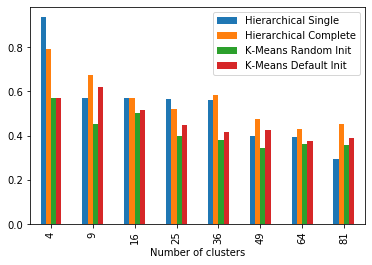

In [67]:
pd.DataFrame(results).plot.bar(x = "Number of clusters",
                                y = ["Hierarchical Single", "Hierarchical Complete", "K-Means Random Init", "K-Means Default Init"])

O gráfico de barras acima mostra que conforme o número de clusters aumenta, o desempenho dos algoritmos em relação a métrica silhueta cai, sendo que os resultados melhores para esta métrica foram para 2 clusters. Ainda, o que se percebe é que o algoritmo hierarquico apresentou resultados melhores do que o K-Means, sendo o hierárquico com ligação completa tendo resultados melhores.

Contudo, o que se pode ocorrer também é que para um número pequeno de clusters, todos os algoritmos estão inserindo outliers em um cluster e o resto em outro, o que acaba por gerar um valor alto do coeficiente.

Quanto ao K-Means, o que se percebe é que utilizar a inicialização aleatória acabou por degradar o desempenho deste algoritmo se comparado ao K-Means com a inicialização padrão.

## Normalização dos dados
Normalizar os dados para reexecutar os algoritmos.

In [14]:
scaler = preprocessing.StandardScaler()

scaled = pd.DataFrame(scaler.fit_transform(df), columns = df.columns.values)

scaled.head()

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,link,photo,status,video,day,month,year,time
0,0.646104,0.323350,1.686879,0.482727,1.983266,0.196196,0.076713,0.473570,-0.155748,-0.094957,-1.245993,-0.233666,1.421466,0.832651,0.711213,-0.718661,-0.330879
1,-0.173192,-0.252206,-0.304144,-0.144720,-0.318454,-0.147879,-0.176010,-0.152587,-0.155748,-0.094957,0.802573,-0.233666,-0.703499,0.832651,0.596638,-0.718661,2.091085
2,-0.006738,0.013089,0.129017,-0.024571,0.206938,-0.033187,0.076713,-0.152587,-0.155748,-0.094957,-1.245993,-0.233666,1.421466,0.832651,0.596638,-0.718661,-0.289911
3,-0.257499,-0.252206,-0.304144,-0.231495,-0.318454,-0.147879,-0.176010,-0.152587,-0.155748,-0.094957,0.802573,-0.233666,-0.703499,0.832651,0.596638,-0.718661,-0.839371
4,-0.037003,-0.252206,-0.304144,-0.024571,-0.093286,-0.147879,-0.176010,-0.152587,-0.155748,-0.094957,0.802573,-0.233666,-0.703499,0.832651,0.252911,-0.718661,-0.711646


In [87]:
results_scaled = []
labels_kr = []
labels_kdi = []
labels_hs = []
labels_hc = []

for i in iterations:
    hierarchical_single = cluster.AgglomerativeClustering(n_clusters = i, linkage = "single")
    hierarchical_complete = cluster.AgglomerativeClustering(n_clusters = i, linkage = "complete")
    
    kmeans_random = cluster.KMeans(n_clusters = i, init = "random").fit(scaled)
    kmeans_default_init = cluster.KMeans(n_clusters = i).fit(scaled) #default init = k-means++
    
    hierarchical_single_clustered =  scaled.assign(cluster_number = hierarchical_single.fit_predict(scaled))
    hierarchical_complete_clustered =  scaled.assign(cluster_number = hierarchical_complete.fit_predict(scaled))
    
    kmeans_random_clustered = scaled.assign(cluster_number = kmeans_random.predict(scaled))
    kmeans_default_init_clustered = scaled.assign(cluster_number = kmeans_default_init.predict(scaled))
    
    labels_kr.append(kmeans_random_clustered)
    labels_kdi.append(kmeans_default_init_clustered)
    labels_hs.append(hierarchical_single_clustered)
    labels_hc.append(hierarchical_complete_clustered)
    
    results_scaled.append({"Number of clusters": i, 
                    "Hierarchical Single": 
                    metrics.silhouette_score(hierarchical_single_clustered, labels = hierarchical_single_clustered['cluster_number']),
                    "Hierarchical Complete":
                    metrics.silhouette_score(hierarchical_complete_clustered, labels = hierarchical_complete_clustered['cluster_number']),
                    "K-Means Random Init":
                    metrics.silhouette_score(kmeans_random_clustered, labels = kmeans_random_clustered['cluster_number']),
                    "K-Means Default Init":
                    metrics.silhouette_score(kmeans_default_init_clustered, labels = kmeans_default_init_clustered['cluster_number'])})

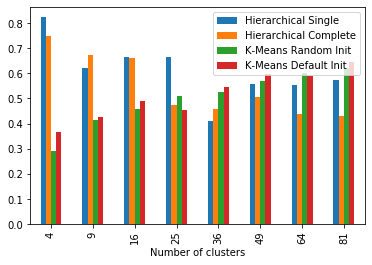

In [69]:
pd.DataFrame(results_scaled).plot.bar(x = "Number of clusters",
                                y = ["Hierarchical Single", "Hierarchical Complete", "K-Means Random Init", "K-Means Default Init"])

Desta vez, o que se vê é que conforme o número de clusters aumenta, o desempenho dos dois tipos de hierárquico utilizados caem, enquanto o K-Means aumenta de desempenho. Sendo que, para um número de clusters maior o hierárquico com ligação simples foi melhor do que o com ligação completa, diferentemente daquilo observado na execução sem normalização.

Ainda, a queda de desempenho observada no hierárquico conforme o número de clusters aumenta é menor do que a observada anteriormente.

Mais uma vez, a inicialização aleatória dos centroídes no K-Means resultou em um desempenho inferior se comparado a inicialização padrão, contudo, para um número de clusters igual a 2 e 9, não se percebe diferença entre a inicialização utilizada.

Por fim, o que se têm por esses resultados é que para um pequeno número de clusters o hierárquico aparenta ser o melhor algoritmo, independente da ligação utilizada, enquanto que para um número maior de clusters, o K-Means é uma escolher mais adequada.

## Visualização dos Clusters
Nesta seção é utilizada a redução de dimensionalidade usando T-SNE para visualizar os clusters encontrados. O T-SNE será executado a partir da base de dados normalizada, depois é realizada a visualização dos clusters obtidos cruzando as labels dadas pelos algoritmos executados anteriormente com a nova base de dados.

In [54]:
try:
    #Lembrar de apagar este arquivo se o preprocessamento mudar!
    tsne_df = pd.read_csv('tsne.csv', delimiter = ',') # Economia de operações
except:
    tsne = manifold.TSNE(n_components = 2)
    tsne_df = pd.DataFrame(tsne.fit_transform(scaled))
    tsne_df.to_csv('tsne.csv', index = False)

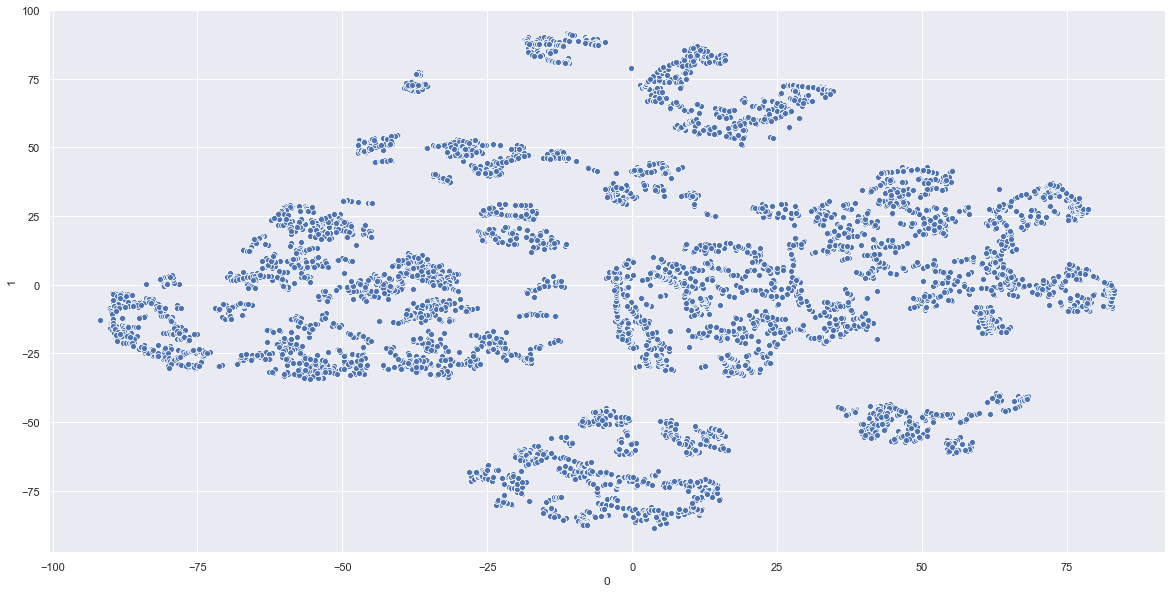

In [76]:
sns.set(rc = {'figure.figsize':(20, 10)})
sns.scatterplot(x = tsne_df['0'], y = tsne_df['1'], legend = False)

O gráfico de dispersão acima, mostra dá uma ideia de como os objetos da base de dados poderiam ser agrupados, por exemplo, é possível ver na região inferior dois grupos mais separados.

Inicialmente, vejamos como foi feito o agrupamento do Hierárquico Simples utilizando 4 clusters, que foi justamente o melhor resultado obtido para este algoritmo com a base de dados normalizada:

0    7047
3       1
2       1
1       1
Name: cluster_number, dtype: int64

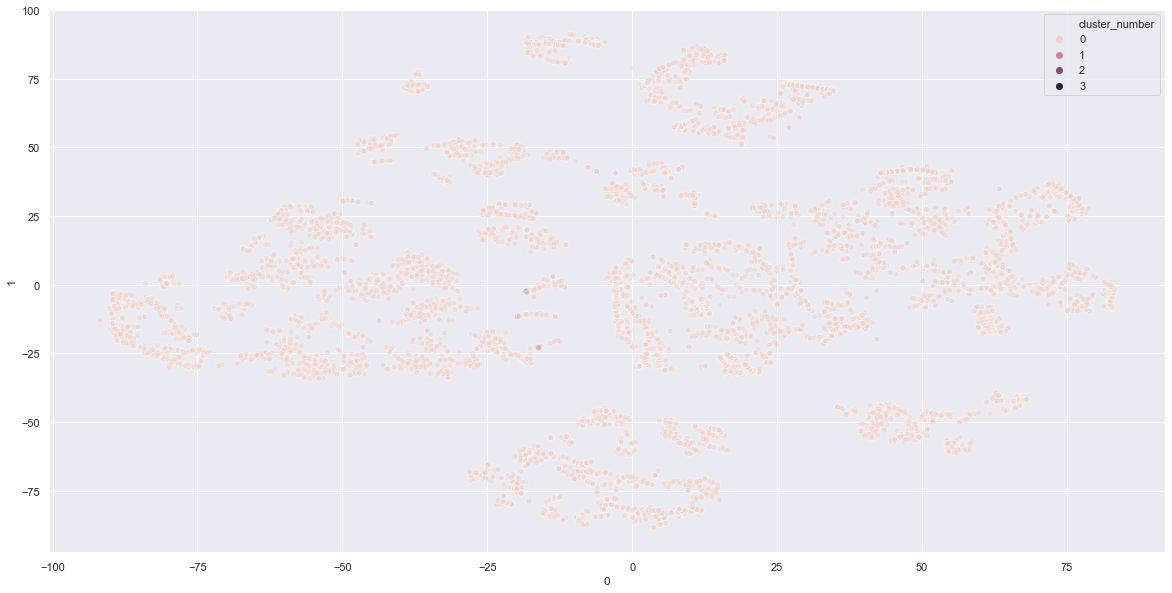

In [79]:
sns.scatterplot(x = tsne_df['0'], y = tsne_df['1'], hue = labels_hs[0]['cluster_number'], legend = 'brief', alpha = 0.5)
labels_hs[0]['cluster_number'].value_counts()

Pela visualização do gráfico acima, o que se percebe é existem três clusters com apenas um objeto, e outro contendo o resto, sendo que os três clusters de um objeto só estão sobrepostos em relação ao cluster maior, mesmo assim a métrica silhueta obtida para este algoritmo foi a mais alta usando o número de clusters igual a 4. Aparentemente, no espaço altamente dimensional original, estes objetos se encontravam afastados dos outros, e por isso acabaram solitários em clusters separados, gerando assim um valor maior para a silhueta.

Ainda em relação ao hierárquico, vejamos como o simples se saiu com um número maior de clusters:

4     4237
15    1226
7      363
62     265
2      195
      ... 
73       1
69       1
57       1
53       1
77       1
Name: cluster_number, Length: 81, dtype: int64

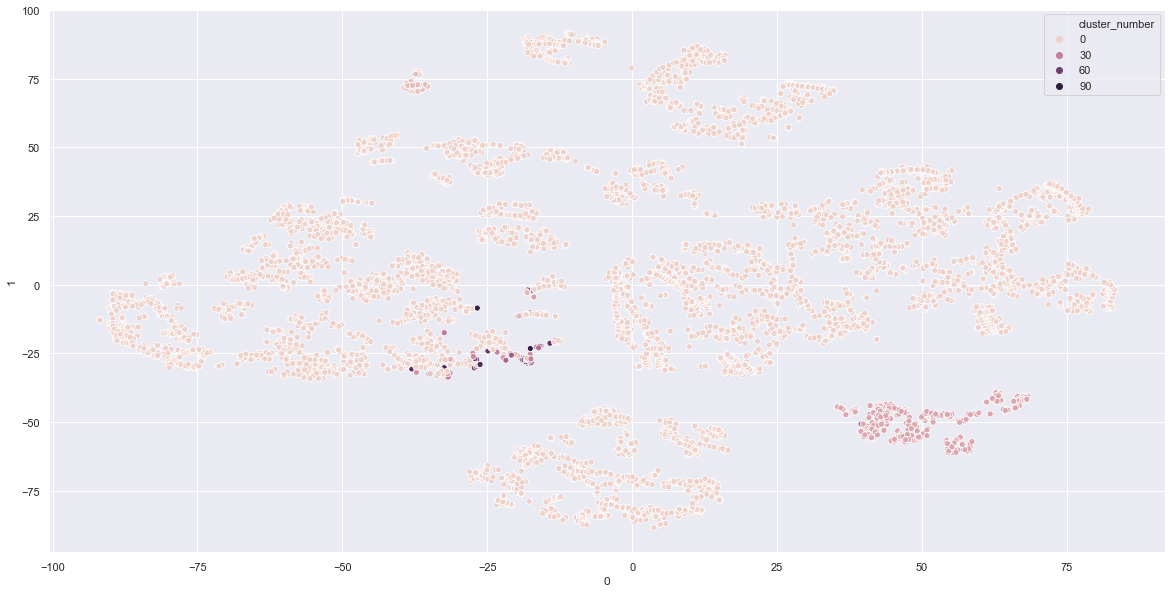

In [81]:
sns.scatterplot(x = tsne_df['0'], y = tsne_df['1'], hue = labels_hs[7]['cluster_number'], legend = 'brief')
labels_hc[7]['cluster_number'].value_counts()

Desta vez, apesar das cores utilizadas não ajudarem muito, é possível ver que os clusters gerados contém mais objetos, e também se encontram melhor definidos, contudo, ainda há uma área perto da região central do gráfico, que apresenta um alto número de clusters sobrepostos, onde aparentemente, cada um contém um pequeno número de objetos.

Antes de passarmos para o K-Means vejamos o resultado do hierárquico completo para 4 clusters:

0    7032
1      14
2       3
3       1
Name: cluster_number, dtype: int64

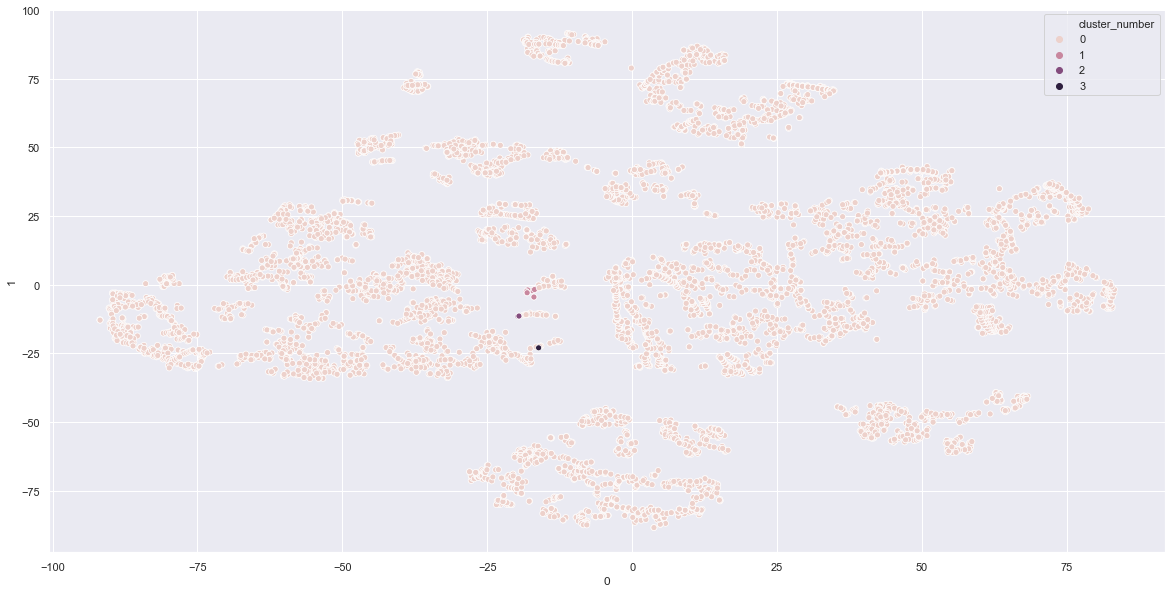

In [83]:
sns.scatterplot(x = tsne_df['0'], y = tsne_df['1'], hue = labels_hc[0]['cluster_number'], legend = 'brief')
labels_hc[0]['cluster_number'].value_counts()

Em comparação com o simples, pode-se ver que apesar de o hierárquico completo colocar um cluster contendo quase todos os objetos, um dos clusters menores contém uma quantidade maior que 1 objeto.

Em si, o que se tem é que ambos os algoritmos hierarquicos obtiveram um valor maior para silhueta pelo fato de que puseram os outliers (no espaço dimensional original) em clusters separados do resto da base de dados, sendo assim, acabaram por terem uma alta diferença intercluster.

Por fim, vejamos como o K-Means saiu, usando 4 como número de clusters, inicialmente, eis o gráfico de dispersão do K-Means com inicialização aleatória:

3    4070
2    2393
0     368
1     219
Name: cluster_number, dtype: int64

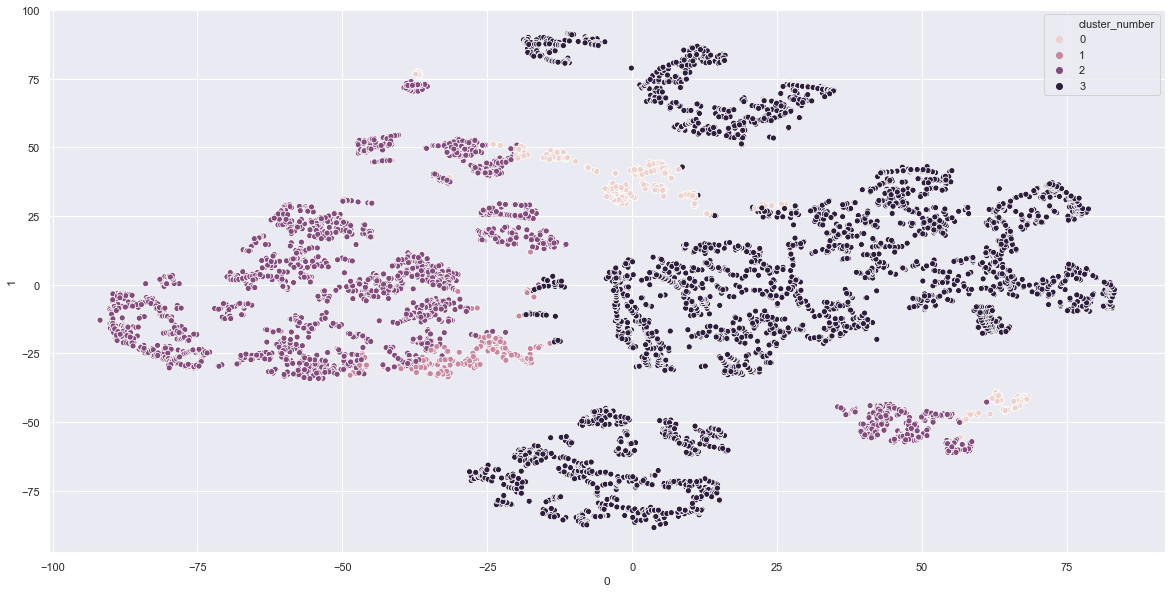

In [88]:
sns.scatterplot(x = tsne_df['0'], y = tsne_df['1'], hue = labels_kr[0]['cluster_number'], legend = 'brief')
labels_kr[0]['cluster_number'].value_counts()

Apesar de ter obtido um valor menor para a silhueta, é possível ver que o K-Means colocou os clusters de maneira que um objeto não fique sozinho em um cluster, é possível ver que a métrica silhueta foi menor pelo fato de que o cluster 1 está sobrepondo parcialmente o 2, enquanto que o cluster 3 sobrepoe o cluster 0 e 2, sendo o 0 praticamente sobreposto por completo com o 3.

Por fim, vejamos o K-Means com a inicialização padrão:

0    4070
1    2393
2     368
3     219
Name: cluster_number, dtype: int64

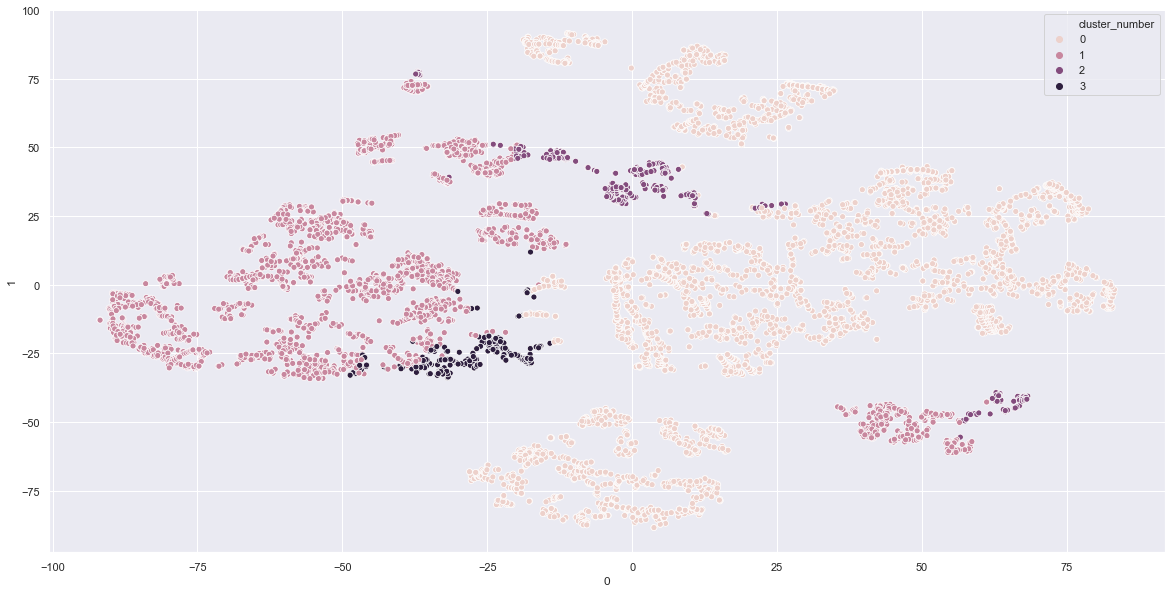

In [89]:
sns.scatterplot(x = tsne_df['0'], y = tsne_df['1'], hue = labels_kdi[0]['cluster_number'], legend = 'brief')
labels_kdi[0]['cluster_number'].value_counts()

Os resultados se assemelham a aqueles vistos com a inicilização padrão, novamente houveram casos em que clusters se sobrepuseram parcialmente (2 e 0), enquanto outros em que a sobreposição foi praticamente total (3 e 1). O que se percebe é que, visualmente, a inicialização não impacta muito nos formatos dos clusters obtidos.

Por fim, diferentemente daquilo visto no Hierárquico o K-Means resultou em um agrupamento diferente, não colocando o outlier em um agrupamento e o resto em outro. Ainda, percebe-se o motivo pelo qual obteve um desempenho inferior na métrica silhueta: parte dos clusters estão sobrepostos, o que acaba por diminuir o valor desta métrica.

## Conclusão
Escolher o melhor algoritmo dependerá muito do critério a ser utilizado, se visto apenas pela silhueta, poderiamos concluir que o hierarquico é superior ao K-Means para um número menor de clusters e o contrário para um número maior.

Enquanto que, se observado visualmente, percebe-se que o hierárquico tratou de gerar clusters com apenas um ou poucos objetos, e colocando a maioria esmagadora em outro, o que acaba por dar um valor maior a silhueta. Do lado do K-Means, independente da inicialização utilizada, o que se observou é que os clusters foram gerados sem colocar um objeto sozinho em um cluster qualquer, contudo, para um valor baixo de clusters, a sobreposição destes é evidente, o que leva a um valor menor da métrica silhueta.

Conclui-se então que o algoritmo K-Means é melhor para agrupar os dados desta base, utilizando valores acima de 10 para o número de clusters.